### Step 1: Import Datasets and merge

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load macroeconomic and forex datasets
macro = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")
forex = pd.read_csv("forex_merged_cleaned.csv", parse_dates=["DATE"]).set_index("DATE")

In [3]:
print("Macro Data:")
print(macro.head(25))

print("\nForex Data:")
print(forex.head(25))

Macro Data:
            Trade Balance  Inflation (CPI)  Core Inflation  Interest Rate  \
DATE                                                                        
2002-01-01       -29678.0            177.7           188.7           1.73   
2002-02-01       -32501.0            178.0           189.1           1.74   
2002-03-01       -31161.0            178.5           189.2           1.73   
2002-04-01       -33965.0            179.3           189.7           1.75   
2002-05-01       -34026.0            179.5           190.0           1.75   
2002-06-01       -34732.0            179.6           190.2           1.75   
2002-07-01       -33913.0            180.0           190.5           1.73   
2002-08-01       -36385.0            180.5           191.1           1.74   
2002-09-01       -36088.0            180.8           191.3           1.75   
2002-10-01       -35095.0            181.2           191.5           1.75   
2002-11-01       -39515.0            181.5           191.9      

In [4]:
# Convert exchange rates to log returns
log_returns = np.log(forex / forex.shift(1))
log_returns = log_returns.dropna()
log_returns.columns = [col + " Return" for col in log_returns.columns]

In [5]:
# Align and merge macro with log returns on DATE

LAG_PERIODS   = (1, 2, 3, 4,5,12,24,60)          
ROLL_WINDOWS  = (3, 5, 7,10)             


def enrich_macro_safe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create lag & rolling features with NO look-ahead bias.
    All features at time t use data ≤ t-1.
    """
    fea = df.copy()                        # t-level original values

    # 1) Lags (t-p)
    for p in LAG_PERIODS:
        fea = pd.concat([fea,
                         df.shift(p).add_suffix(f"_lag{p}")],
                        axis=1)

    # 2) Rolling statistics over past window (up to t-1)
    for w in ROLL_WINDOWS:
        roll_mean = (
            df.rolling(w).mean()   # mean of [t-w+1 … t]
              .shift(1)            # now window is [t-w … t-1]
              .add_suffix(f"_rollmean{w}")
        )
        roll_std  = (
            df.rolling(w).std()
              .shift(1)
              .add_suffix(f"_rollstd{w}")
        )
        fea = pd.concat([fea, roll_mean, roll_std], axis=1)

    # memory-friendly & drop rows that have NaNs due to shifting
    return fea.astype("float32").dropna()

macro_fea = enrich_macro_safe(macro)                       # ← engineered features
full_df   = pd.merge(macro_fea, log_returns,
                     left_index=True, right_index=True,
                     how="inner").dropna()

# Drop rows with any missing data (can customize later)
full_df = full_df.dropna()
full_df.head()

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,...,USD-AUD Return,USD-CAD Return,USD-CHF Return,USD-CNY Return,USD-EUR Return,USD-GBP Return,USD-HKD Return,USD-JPY Return,USD-NZD Return,USD-XAU Return
DATE,,,,,,,,,,,,,,,,,,,,,
2007-02-01,-58479.0,204.225998,209.134995,5.26,100.716599,364006.0,91.300003,4.5,50.400002,1438.239990,...,0.014821,0.009562,0.019480,-0.003954,0.012582,-0.003415,0.003850,0.013681,0.018207,-0.027735
2007-03-01,-62183.0,205.287994,209.417999,5.26,100.895203,367158.0,88.400002,4.4,54.099998,1406.819946,...,-0.014060,-0.005966,-0.019889,-0.004125,-0.015004,0.000814,0.000666,-0.017889,-0.014649,-0.025838
2007-04-01,-60494.0,205.904007,209.746994,5.25,101.572304,366187.0,87.099998,4.5,52.799999,1420.859985,...,-0.025933,-0.013684,-0.003367,-0.001318,-0.009405,-0.001984,0.000077,-0.006176,-0.018365,0.011345
2007-05-01,-59572.0,206.755005,210.057999,5.25,101.626900,370934.0,88.300003,4.4,52.700001,1482.369995,...,-0.026242,-0.039144,-0.006769,-0.003654,-0.021777,-0.015981,0.001138,0.014324,-0.035883,-0.022141
2007-06-01,-59997.0,207.233994,210.391998,5.25,101.654701,368154.0,85.300003,4.6,53.099998,1530.619995,...,0.002654,-0.037460,0.014799,-0.007466,0.014391,0.009901,-0.001881,0.018238,0.005009,0.026775


### Step 2: Run OLS Regression per Currency

In [7]:
import statsmodels.api as sm

# 1. Identify columns
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# 2. Store results
results = []

# 3. Loop through each currency return and run OLS
for target in fx_targets:
    X = full_df[macro_vars]
    y = full_df[target]
    
    # Add intercept
    X_const = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X_const).fit()
    
    # Store results
    results.append({
        "Currency": target.replace(" Return", ""),
        "R_squared": model.rsquared,
        "Adj_R_squared": model.rsquared_adj,
        "Coefficients": model.params.to_dict(),
        "P_values": model.pvalues.to_dict()
    })

In [8]:
# Flatten into a readable summary table
summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in results],
    "R_squared": [res["R_squared"] for res in results],
    "Adj_R_squared": [res["Adj_R_squared"] for res in results]
})

summary.sort_values("R_squared", ascending=False, inplace=True)
summary.head(10)

,Currency,R_squared,Adj_R_squared
0,USD-AUD,0.258532,0.218746
1,USD-CAD,0.244302,0.203753
8,USD-NZD,0.217361,0.175365
5,USD-GBP,0.159755,0.114669
4,USD-EUR,0.124700,0.077733
7,USD-JPY,0.104298,0.056236
3,USD-CNY,0.103325,0.055211
2,USD-CHF,0.083553,0.034377
9,USD-XAU,0.069484,0.019554
6,USD-HKD,0.053268,0.002468


In [9]:
# Create a DataFrame with currencies as rows and macro variables as columns
coeff_matrix = pd.DataFrame()

# Loop through results and pull each currency's coefficients
for res in results:
    currency = res["Currency"]
    coeffs = res["Coefficients"]
    
    # Convert to Series and name it with the currency
    coeff_series = pd.Series(coeffs, name=currency)
    
    # Append as a new row to the matrix
    coeff_matrix = pd.concat([coeff_matrix, coeff_series.to_frame().T], axis=0)

# Set currency names as the index
coeff_matrix.index.name = "Currency"

# Drop the constant (intercept) column if you only want macro variable effects
coeff_matrix = coeff_matrix.drop(columns="const", errors='ignore')

pd.set_option('display.float_format', '{:.9f}'.format)
coeff_matrix.head(10)

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,VIX Index
Currency,,,,,,,,,,,
USD-AUD,-0.000000066,0.007427035,-0.006128466,-0.000592360,0.000976226,-0.000000288,0.001784992,-0.002946155,0.000441263,0.000002498,0.003182949
USD-CAD,-0.000000183,0.002991707,-0.001660344,-0.001818739,0.002291232,-0.000000313,0.000670222,-0.000465399,0.000095899,-0.000003124,0.001937800
USD-CHF,-0.000000220,0.003862743,-0.003612672,-0.000727786,-0.000623662,0.000000037,0.001198314,-0.000914718,0.000069904,-0.000003614,0.001357666
USD-CNY,-0.000000039,0.000714928,-0.000418831,-0.000425064,-0.000138426,0.000000032,0.000278623,-0.000621958,-0.000022509,-0.000007991,0.000328555
USD-EUR,0.000000002,0.004028923,-0.003508384,-0.000964376,0.000033621,-0.000000118,0.000883058,-0.001613894,0.000468879,0.000003667,0.001651943
USD-GBP,-0.000000461,0.002140739,-0.001332757,-0.002076201,0.000086896,-0.000000150,0.000604168,-0.003315394,-0.000048323,-0.000008923,0.001416011
USD-HKD,-0.000000023,-0.000039548,0.000016994,-0.000097083,-0.000059534,0.000000013,0.000004839,-0.000121398,0.000022374,-0.000000852,-0.000016195
USD-JPY,-0.000000251,0.003157865,-0.003500432,-0.002262105,-0.000913028,0.000000276,0.000831919,0.001442401,-0.000573726,-0.000008125,-0.000262253
USD-NZD,-0.000000018,0.005775317,-0.004886043,-0.000338180,0.001247991,-0.000000191,0.001390696,-0.002839134,0.000392226,0.000001786,0.003142000


### STEP 3: Train a Predictive Model (Lasso)

In [11]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Define train/test split
train_end = "2022-12-31"

# Training set: data until end of 2022
train_df = full_df.loc[:train_end]

# Test set: data from 2023 onward
test_df = full_df.loc["2023-01-01":]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (191, 197)
Test shape: (26, 197)


In [13]:
# Macro variables (predictors) and currency returns (targets)
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# Define X and Y for train and test
X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [14]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

lasso_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    lasso = Lasso(alpha=0.001, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    
    # Calculate error metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)   
    
    # Store
    lasso_results.append({
        "Currency": target.replace(" Return", ""),
        "RMSE": rmse,
        "MAE": mae,
        "R_squared": r2,   
        "Model": lasso,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [15]:
# Create a summary DataFrame
lasso_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in lasso_results],
    "R_squared": [res["R_squared"] for res in lasso_results],
    "RMSE": [res["RMSE"] for res in lasso_results],
    "MAE": [res["MAE"] for res in lasso_results]
})

# Sort by R-squared
lasso_summary = lasso_summary.sort_values("R_squared", ascending=False)
print(lasso_summary.head(10))

  Currency    R_squared        RMSE         MAE
6  USD-HKD  0.014472051 0.002197578 0.001644922
9  USD-XAU -0.070458728 0.038221626 0.031802254
7  USD-JPY -0.155834532 0.035382388 0.027990275
3  USD-CNY -0.321759041 0.016929960 0.013076103
2  USD-CHF -1.088893814 0.033918093 0.028902316
5  USD-GBP -1.206497405 0.028060591 0.023916442
0  USD-AUD -2.223909344 0.047086377 0.041016866
4  USD-EUR -2.269846991 0.034113366 0.029490625
1  USD-CAD -2.381855438 0.029875826 0.026285691
8  USD-NZD -2.955249014 0.058748243 0.050728113


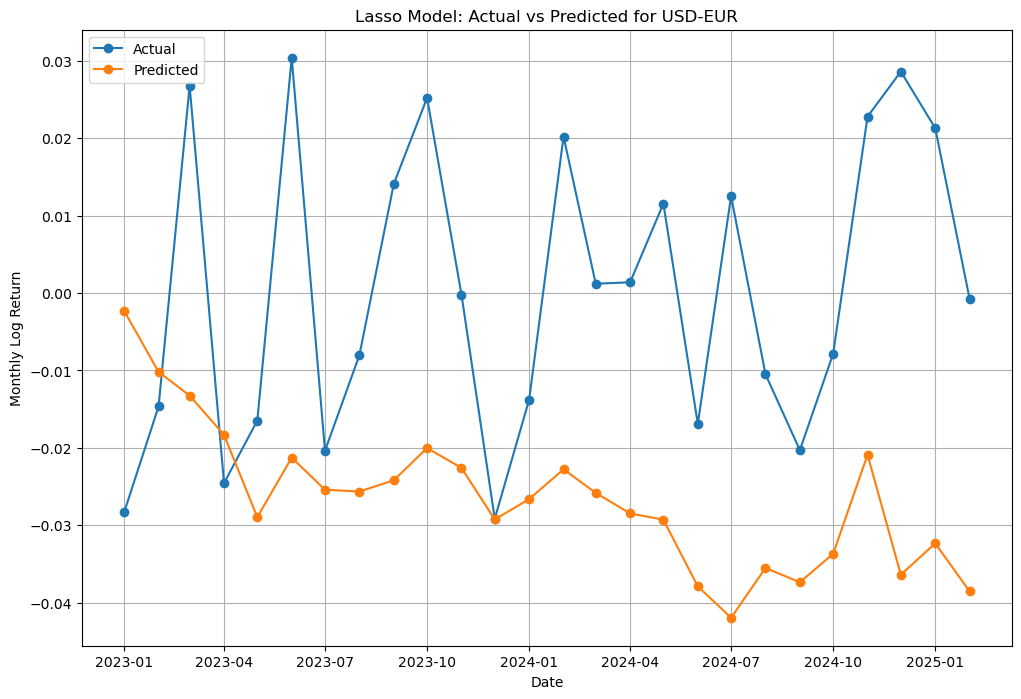

In [16]:
# Example: Plot for one currency (e.g., USD-EUR)
currency_to_plot = "USD-EUR"

for res in lasso_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"Lasso Model: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break

### STEP 4: Train a Predictive Model (XGBoost)

In [18]:
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [19]:
# Inputs and outputs
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [46]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

xgb_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    # Initialize XGBoost model
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    
    # Fit the model
    xgb.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = xgb.predict(X_test)
    
    # Evaluate
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # ADD THIS LINE
    
    # Store results
    xgb_results.append({
        "Currency": target.replace(" Return", ""),
        "R_squared": r2,          
        "RMSE": rmse,
        "MAE": mae,
        "Model": xgb,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [48]:
# Create summary table
xgb_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in xgb_results],
    "R_squared": [res["R_squared"] for res in xgb_results],   
    "RMSE": [res["RMSE"] for res in xgb_results],
    "MAE": [res["MAE"] for res in xgb_results]
})

# Sort by R_squared (higher is better)
xgb_summary = xgb_summary.sort_values("R_squared", ascending=False)

print(xgb_summary.head(10))

  Currency    R_squared        RMSE         MAE
4  USD-EUR -0.084787770 0.019648674 0.016534762
1  USD-CAD -0.099399234 0.017034136 0.014785572
9  USD-XAU -0.209373756 0.040626037 0.030999143
3  USD-CNY -0.261653355 0.016540545 0.013620467
0  USD-AUD -0.314720955 0.030069116 0.024308234
2  USD-CHF -0.372204943 0.027490506 0.023442995
7  USD-JPY -0.681072199 0.042670967 0.034284894
6  USD-HKD -1.226952530 0.003303432 0.002656733
5  USD-GBP -1.519877926 0.029987127 0.024568984
8  USD-NZD -1.902974013 0.050330302 0.044162914


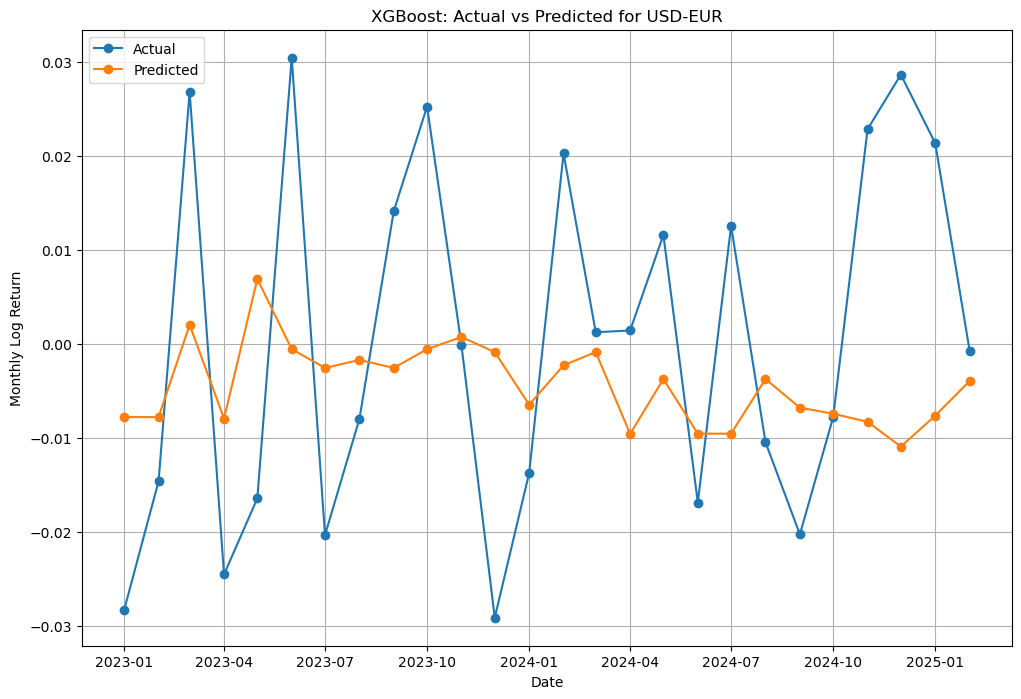

In [22]:
import matplotlib.pyplot as plt

currency_to_plot = "USD-EUR"

for res in xgb_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"XGBoost: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break